# Part 3: Steric height
Andrew Delman. Updated 2023-01-07.

## Objectives

To use ECCO state output to investigate steric height anomalies.

By the end of this tutorial, you will be able to:
* Compute steric height anomaly (SHA)
* Compare SHA with sea surface height
* Estimate contributions of temperature and salinity to SHA

## Steric height anomaly computation

### Formulation

Though the density of ocean water changes relatively little compared to the density of air and other gases, even relatively small variations in ocean water density have large impacts on the ocean circulation and sea level variations. Under the conditions of hydrostatic balance (conditions assumed by the MITgcm model configuration run in ECCO v4r4), the vertical gradient of pressure $\partial{p}/\partial{z}$ is a function of density $\rho$ and gravitational acceleration $g$:

$$
\frac{\partial{p}}{\partial{z}} = -{\rho}g
$$

When the density of a parcel water changes, e.g. because its temperature or salinity changes, the parcel of water expands or contracts, and this has an effect on the vertical height of the parcel. This can be expressed in terms of the change in height between two pressure surfaces.

$$
{\Delta}z = \frac{{\Delta}p}{-{\rho}g}
$$

or in integral form

$$
h = \int_{p_r}^{p} \frac{dp}{-{\rho}g}
$$

which can also be notated in terms of the specific volume $\alpha \equiv 1/\rho$

$$
h = \int_{p_r}^{p} -\frac{\alpha}{g} \, dp
$$

where $h$ is the steric height at pressure level $p$ relative to some reference pressure level $p_r$. Generally we are less interested in the value of the steric height itself than in its spatial or temporal variation, so the steric height anomaly $h^{\prime}$ can be defined in terms of a specific volume anomaly $\alpha^{\prime}$

$$
h^{\prime} = \int_{p_r}^{p} -\frac{\alpha^{\prime}}{g} \, dp
$$

where $\alpha^{\prime}$ is the anomaly from the a reference specific volume $\alpha_r$.

### GSW-Python module

To help carry out computations involving seawater density and related quantities such as specific volume, we will use the [GSW-Python module](https://teos-10.github.io/GSW-Python/), an implementation of the Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10. Th is especially helpful in computations involving the nonlinear [equation of state](https://www.teos-10.org) that relates temperature, salinity, pressure, and density, which is quite complicated (the formulation of density for example has 75 terms!). If you don't have this module already, you can install it using "*conda install -c conda-forge gsw*" or "*pip install gsw*".

Note that a [function that computes steric height anomaly](http://www.teos-10.org/pubs/gsw/html/gsw_steric_height.html) is already part of the GSW toolbox for Matlab and some other programming languages, but has not yet been implemented in the Python module. That's OK, because it is fairly straightforward to implement this function in Python ourselves, especially when ECCO v4r4 already provides density and pressure as outputs. We *can* use GSW-Python to compute the reference specific volume $\alpha_r$, using GSW's definition of $\alpha_r$ as the specific volume at a given pressure level with a conservative temperature of 0 deg C and absolute salinity of 35.16504 g/kg.

### Compute specific volume anomaly

In [1]:
# first import needed packages
import numpy as np
import xarray as xr
import xmitgcm
import xgcm
import glob
from os.path import expanduser,join
import sys
user_home_dir = expanduser('~')
sys.path.append(user_home_dir + '/ECCOv4-py')   # only needed if ecco_v4_py files are stored under this directory
import matplotlib.pyplot as plt
import ecco_v4_py as ecco
import gsw

In [2]:
# now open density and grid parameter files

# ShortNames
denspress_monthly_shortname = "ECCO_L4_DENS_STRAT_PRESS_LLC0090GRID_MONTHLY_V4R4"
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"

# density file
download_root_dir = join(user_home_dir,'Downloads/ECCO_V4r4_PODAAC')
download_dir = join(download_root_dir,denspress_monthly_shortname)
curr_denspress_file = list(glob.glob(download_dir + '/*2000-01*.nc'))
ds_denspress = xr.open_dataset(curr_denspress_file[0])

# grid parameters file
grid_params_file = "GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc"
grid_params_file_path = join(download_root_dir,grid_params_shortname,grid_params_file)
ds_grid = xr.open_dataset(grid_params_file_path)


g = 9.81
rhoConst = 1029.
p_atm = 101325.   # atmospheric pressure at sea surface, in Pa
press = (ds_denspress.PHIHYDcR + (g*(-ds_grid.Z)))*rhoConst   # pressure
press_sea = press - p_atm    # pressure minus mean atmospheric pressure

dens = ds_denspress.RHOAnoma + rhoConst   # in-situ density

# compute standard specific volume and anomalies
SA_standard = 35.16504    # absolute salinity standard for spec. vol., notated as SSO in GSW documentation
CT_standard = 0.    # conservative temperature standard
# arrays need to be reshaped for GSW (input arrays can have 2 dimensions max)
press_sea_reshaped = np.reshape(press_sea.values,(1,len(ds_denspress.k),-1)).squeeze()
specvol_standard = gsw.density.specvol(SA_standard,CT_standard,(1.e-4)*press_sea_reshaped)
specvol_standard = np.reshape(specvol_standard,press_sea.shape)
specvol_anom = 1/dens - specvol_standard

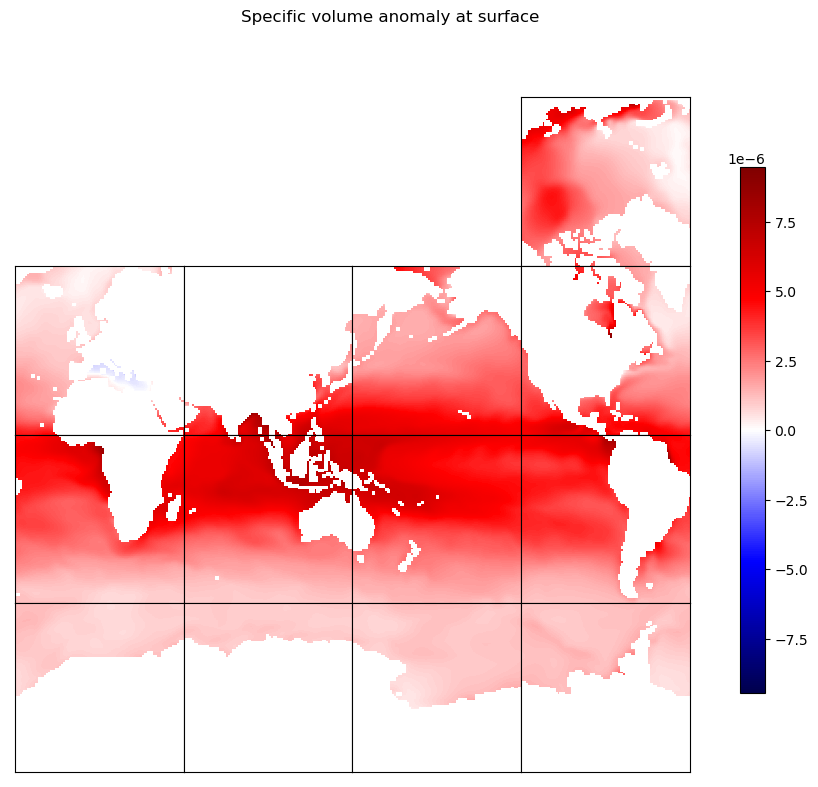

In [3]:
# # plot global tiles map of specific volume anomaly in topmost layer (k=0)

# k index (depth level) to plot
k_plot = 0

# 13 tiles map
curr_obj = ecco.plot_tiles(specvol_anom.isel(k=k_plot).squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10)
curr_fig = curr_obj[0]
curr_fig.suptitle('Specific volume anomaly at surface')

plt.show()

Notice that surface specific volume anomalies are largest in equatorial regions, particularly in the Indo-Pacific warm pool where surface waters are both very warm and relatively fresh (and therefore have relatively low density). Notice also that the specific volume anomaly is positive nearly everywhere, due to how the anomaly has been defined---based on water of temperature 0 C, at a salinity that is typical of ocean water but saltier than most water that cold.

### Compute steric height anomaly

Now we'll vertically integrate in pressure coordinates to obtain the steric height anomaly, relative to some reference pressure. In order to compute the integral in pressure coordinates, the pressure values are first computed at the top and bottom interfaces of each grid cell; then the integral is summed over grid cells above the defined reference pressure level.

In [33]:
# pressure reference level to compute steric height
# (in units of dbar, minus 10.1325 dbar atmospheric pressure)
p_r_sea_dbar = 2000.

# # integrate vertically in pressure coordinates

p_r = ((1.e4)*p_r_sea_dbar) + p_atm

# compute pressure at z = 0 (not exactly the ocean surface)
press_z0 = press.isel(k=[0]) - (0.5*dens.isel(k=[0])*g*ds_grid.drF.isel(k=[0]))
press_z0.Z.values = np.array([ds_grid.Zl[0].values,])
# integrate hydrostatic balance downward to get pressure at bottom of grid cells
press_ku = press_z0.values + (dens*g*ds_grid.drF).cumsum("k")
press_ku.Z.values = ds_grid.Zu.values
# create array with pressure at top of grid cells
press_kl = xr.concat([press_z0,press_ku.isel(k=np.arange(len(ds_grid.k) - 1))],dim="k")
press_kl = press_kl.assign_coords(k=ds_grid.k.values)

Now let's choose sea level pressure $p = p_{\rm{atm}}$ (i.e., sea pressure = 0 dbar) as the top limit of our integration, carry out the integration between these two levels, and plot the resulting map.

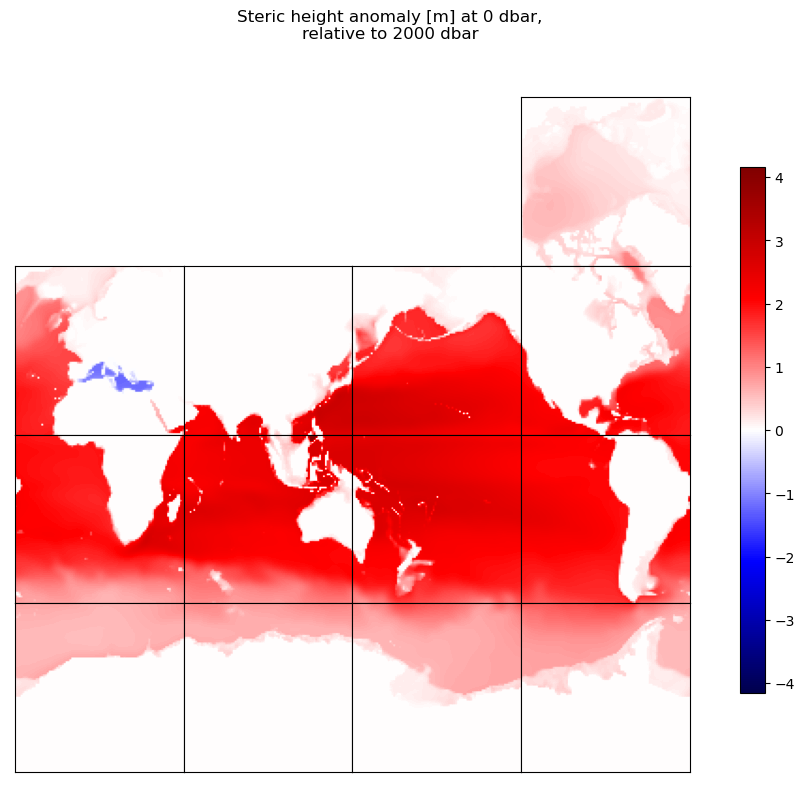

In [43]:
# # compute steric height anomaly at given pressure p_top_sea_dbar, relative to p_r_sea_dbar
p_top_sea_dbar = 0.

p_top = ((1.e4)*p_top_sea_dbar) + p_atm

# compute dp for this integration
dp_integrate =  np.fmax(press_kl,p_top*np.ones(press_kl.shape)) - \
                np.fmin(press_ku,p_r*np.ones(press_ku.shape))
# allow integration above z=0 if p_top is less than p at z=0
p_top_above_z0_mask = (p_top - press_kl.isel(k=0).values < 0)
dp_integrate.isel(k=0).values[p_top_above_z0_mask] = \
                                (p_top - press_ku[:,0,:,:,:].values)[p_top_above_z0_mask]
dp_integrate.values[dp_integrate.values > 0] = 0
steric_hgt_anom = (-(specvol_anom/g)*dp_integrate).sum("k")

# steric_hgt_anom_p_top = np.zeros((1,) + steric_hgt_anom_up.shape[-3:])


# for curr_k in range(steric_hgt_anom_up.shape[1] - 1):
#     if curr_k == 0:
#         # extrapolate above z=0 at surface where necessary
#         in_curr_k_mask = (press_ku.isel(k=curr_k).values - p_top >= 0)
#     else:
#         in_curr_k_mask = np.logical_and(press_kl.isel(k=curr_k).values - p_top < 0,\
#                                        press_ku.isel(k=curr_k).values - p_top >= 0)
#     weight_above = (press_ku.isel(k=curr_k) - p_top_Pa)\
#                     /(press_ku.isel(k=curr_k) - press_kl.isel(k=curr_k))
#     weight_above.values[np.isinf(weight_above.values)] = 1.   # remove non-finite weightings
#     weight_below = 1. - weight_above
#     steric_hgt_above = steric_hgt_anom_up[:,curr_k,:,:,:]
#     steric_hgt_below = steric_hgt_anom_up[:,curr_k+1,:,:,:]
#     steric_hgt_anom_p_top += in_curr_k_mask*((weight_above*steric_hgt_above)\
#                                              + (weight_below*steric_hgt_below))

# # plot global tiles map of steric height at sea level pressure, i.e. sea pressure = 0 dbar
# # relative to p_r_sea_dbar

# 13 tiles map
curr_obj = ecco.plot_tiles(steric_hgt_anom.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10)
curr_fig = curr_obj[0]
curr_fig.suptitle('Steric height anomaly [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

plt.show()

You can certainly make a few observations from the above map; notice the low steric height anomaly values in the high-salinity Mediterranean Sea for example. But there is a potential problem with the steric height anomaly integration, evident in the abrupt discontinuities across continental slopes (look closely at the areas near the Antarctic Peninsula or Argentina). When the bathymetry is shallower than the reference pressure level, this integration has assumed that the land areas are actually water parcels with the standard specific volume.

To avoid potentially misleading results, let's mask out all areas where the bathymetry is shallower than the $p_r$ pressure level. We'll plot this mask in gray along with a surface land mask in black, and for good measure we will rescale the steric height anomaly so that the global mean of the unmasked areas is removed.

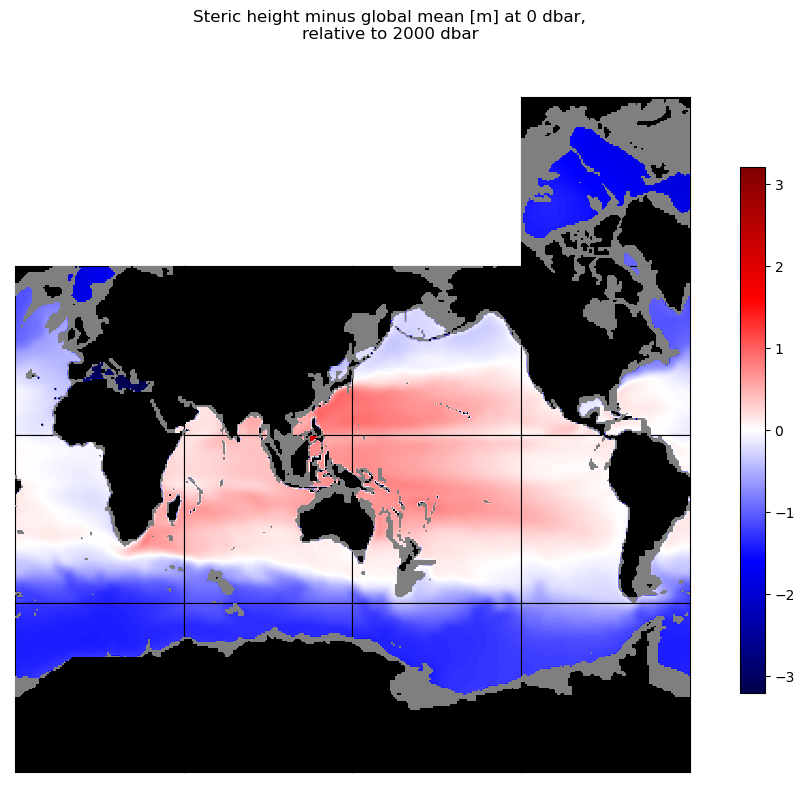

In [54]:
# function to plot mask (same as used in previous tutorials)
from matplotlib.colors import ListedColormap
def plot_mask(*args,ax,color_rgb):
    "Plot mask, given (optional) X and Y, 2-D mask, axes ax, and color_rgb, a 3-element NumPy array"    
    if len(args) == 1:
        mask = args[0]
    else:
        X = args[0]
        Y = args[1]
        mask = args[2]
    # set alpha values to 1 where mask is plotted, 0 otherwise
    if str(type(mask))[0:5] == 'xarray':
        mask = mask.values
    colormap = ListedColormap(np.concatenate((np.tile(color_rgb,(2,1)),np.array([[0],[1]])),axis=-1))
    # plot land mask
    if len(args) == 1:
        ax.imshow(mask,cmap=colormap,vmin=0.,vmax=1.,zorder=50)
    else:
        ax.pcolormesh(X,Y,mask,cmap=colormap,vmin=0.,vmax=1.,zorder=50)
    if np.diff(ax.get_ylim()) < 0:
        ax.set_ylim(ax.get_ylim()[::-1])     # set direction of y-axis so that values increase upward

# load land mask (a boolean array) from grid parameters
land_mask = ~ds_grid.maskC

# surface land mask
land_mask_surf = land_mask.isel(k=0)

# mask out areas where sea pressure never reaches the reference pressure
too_shallow_mask = (press_ku.isel(k=-1) < p_r)

# steric height anomaly global mean, excluding masked areas
unmasked = (~land_mask_surf)*(~too_shallow_mask)
steric_hgt_globmean = np.sum(unmasked*ds_grid.rA*steric_hgt_anom_p_top)\
                        /np.sum(unmasked*ds_grid.rA)
steric_hgt_minus_globmean = steric_hgt_anom - steric_hgt_globmean


# function to plot a mask in ECCO tiles ()
def plot_mask_ecco_tiles(mask,color_rgb):
    """
    Plot mask in global ECCO tiles plot on current axes, 
    given 2-D mask and color_rgb, a 3-element NumPy array.
    """
    # loop through tiles to add mask
    tile_order = np.array([-1,-1,-1,6, \
                             2,5,7,10,  \
                             1,4,8,11, \
                             0,3,9,12])
    for idx,curr_ax in enumerate(curr_fig.get_axes()):
        if len(curr_ax.get_images()) > 0:
            # plot land mask
            array_plot = mask.isel(tile=tile_order[idx]).squeeze()
            if tile_order[idx] == 6:
                array_plot = np.rot90(array_plot,2)
            elif tile_order[idx] > 6:
                array_plot = np.rot90(array_plot)
            plot_mask(array_plot,ax=curr_ax,color_rgb=color_rgb)

# 13 tiles map
curr_obj = ecco.plot_tiles(steric_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask

# add title
curr_fig.suptitle('Steric height minus global mean [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

plt.show()

## Compare steric height with sea surface height

### Retrieve sea surface height output

Steric sea level variation is one of the main components of sea level variation globally, the other being barystatic sea level variation associated with the input/output or redistribution of ocean mass. Indeed, the thermal expansion and consequent density reduction in the ocean is known to be one of the drivers of anthropogenic sea level rise. Given its incorporation of ocean data in a physically consistent manner, the ECCO v4r4 state estimate is well suited to examine spatial and temporal sea level variations and the components contributing to them.

To compare steric height with sea surface height, we of course need to download and retrieve sea surface height output from ECCOv4r4. You can do this by using the **ecco_download** module; consulting the [variable list](../varlist/v4r4_nctiles_monthly_varlist.txt) for monthly mean output, we find that the datasets containing sea surface height have ShortName ```ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4```. To start, download the granule of that dataset corresponding to January 2000 (2000-01). Once you have this file downloaded, view its structure using the code below.

In [47]:
# open sea surface height file

SSH_monthly_shortname = "ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4"
# change download_root_dir if the SSH file is not downloaded to the default path listed below
download_root_dir = join(user_home_dir,'Downloads/ECCO_V4r4_PODAAC')  
download_dir = join(download_root_dir,SSH_monthly_shortname)
curr_SSH_file = list(glob.glob(download_dir + '/*2000-01*.nc'))
ds_SSH = xr.open_dataset(curr_SSH_file[0])

ds_SSH

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 2000-01-16T12:00:00
    ...         ...
    YC         (tile, j, i) float32 ...
    XG         (tile, j_g, i_g) float32 ...
    YG         (tile, j_g, i_g) float32 ...
    time_bnds  (time, nv) datetime64[ns] ...
    XC_bnds    (tile, j, i, nb) float32 ...
    YC_bnds    (tile, j, i, nb) float32 ...
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 ...
    SSHIBC     (time, tile, j, i) float32 ...
    SSHNOIBC   (time, tile, j, i) float32 ...
    ETAN       (time, tile, j, i) float32 ...
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2000-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2000-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         a7c2a1c4-400c-11eb-9f79-0cc47a3f49c3

### Comparison

Of the 4 data variables in the SSH dataset, 3 are forms of sea surface height, just with different corrections applied. The ```SSH``` variable is the dynamic sea surface height anomaly. Importantly, it includes the correction for global mean steric effects, often called the Greatbatch correction; this is essential for tracking steric impacts on sea level over time. The inverted barometer (IB) correction is for the effect of atmospheric pressure on sea level; here we will use the ```SSH``` variable which has the IB correction, and best reflects changes in sea level due to ocean mass and density.

<Figure size 640x480 with 0 Axes>

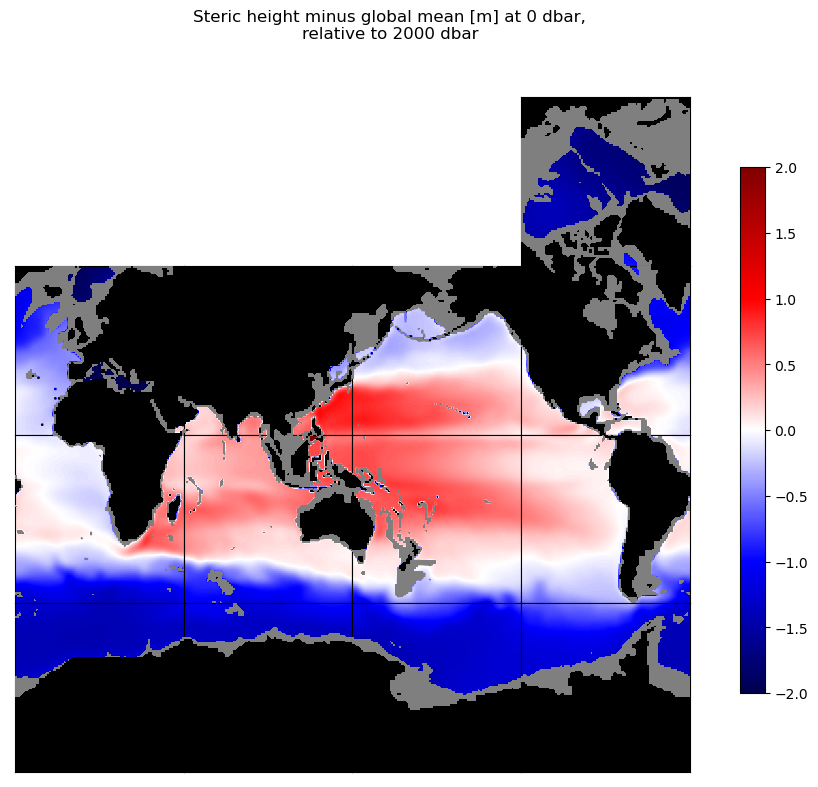

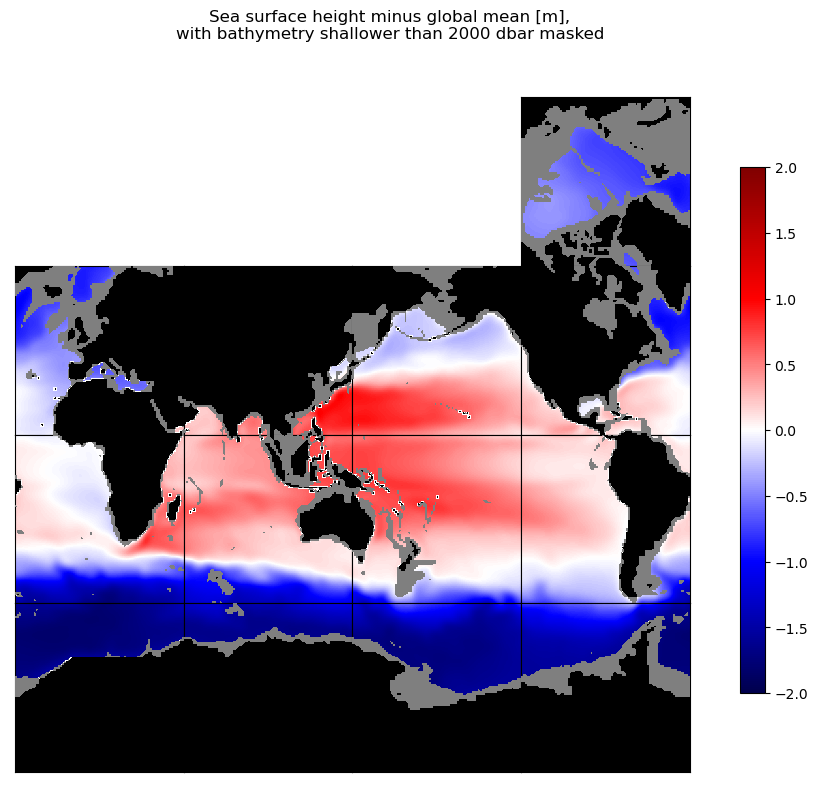

In [65]:
# remove global mean from SSH
SSH_globmean = np.sum((ds_grid.maskC.isel(k=0))*(ds_grid.rA)*ds_SSH.SSH)\
                    /np.sum((ds_grid.maskC.isel(k=0))*(ds_grid.rA))
SSH_minus_globmean = ds_SSH.SSH - SSH_globmean


# plot steric height and SSH minus respective global means

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(2,1)

curr_fig = subfigs[0]
# 13 tiles map
curr_obj = ecco.plot_tiles(steric_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Steric height minus global mean [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

curr_fig = subfigs[1]
# 13 tiles map
curr_obj = ecco.plot_tiles(SSH_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Sea surface height minus global mean [m],\n' + \
                    'with bathymetry shallower than ' + str(int(p_r_sea_dbar)) + ' dbar masked')

plt.show()

Notice how similar these maps are, even though steric height is only one of the two primary components of sea level variation, and that the steric height map only includes the effect of density variations above 2000 dbar. A little more insight can be gained by taking the difference between the maps above to look at the non-steric height variation:

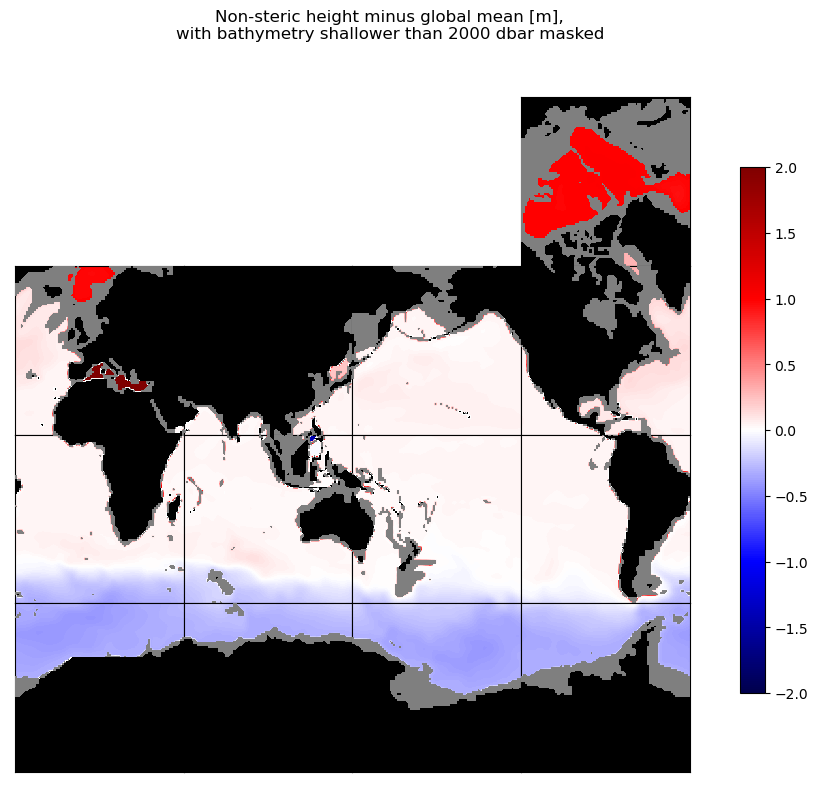

In [66]:
nonsteric_hgt_minus_globmean = SSH_minus_globmean - steric_hgt_minus_globmean

# 13 tiles map
curr_obj = ecco.plot_tiles(nonsteric_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Non-steric height minus global mean [m],\n' + \
                  'with bathymetry shallower than ' + str(int(p_r_sea_dbar)) + ' dbar masked')

plt.show()

The map above implies that non-steric effects (or steric effects deeper than 2000 dbar) on the regional variation of sea level are relatively small, with a few notable exceptions. For example, south of the Antarctic Circumpolar Current (ACC), SSH is much lower than might be expected from 0-2000 dbar steric height anomalies, suggesting that either (a) deep ocean steric anomalies must explain the discrepancy, or (b) a gradient in vertically-integrated ocean mass (i.e. deep ocean pressure) is sustained across the ACC. Which explanation do you think it is, and how might we test that hypothesis?

## Thermosteric and halosteric contributions

In [50]:
SSH_minus_globmean

<xarray.DataArray (time: 1, tile: 13, j: 90, i: 90)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [-1.60994613e+00, -1.61482084e+00, -1.61311650e+00, ...,
          -1.42578459e+00, -1.41092205e+00, -1.39642775e+00],
         [-1.58488846e+00, -1.58950627e+00, -1.58623135e+00, ...,
          -1.42281950e+00, -1.40500879e+00, -1.38644743e+00],
         [-1.55262351e+00, -1.55429471e+00, -1.54865098e+00, ...,
          -1.42149043e+00, -1.40135550e+00, -1.37914324e+00]],

        [[-1.51187384e+00, -1.50954020e+00, -1.50304437e+00, ...,
          -1.41943717e+00, -1.39751601e+00, -1.37236226e+00],
         [-1.46660566e+00, -1.46158314e+00, -1.45798898e+00, ...,
          -1.41496921e+00, -1.39186382e+00, -1.36458397e+00],
         [-1.42771435e+00, -1.42286396e+00, -1.42558920e+00, ...,
          -1.40573549e+00, -1.38221896e+00, -1.35398352e+00],
...
          -1.38095152e+00, -1.40461075e+00, -1.43429172e+00],
         [-5.60708568e-02, -4.15062234e-02, -2.27705315e-02, ...,
          -1.40680325e+00, -1.43559182e+00, -1.46942246e+00],
         [-5.30894548e-02, -3.71797085e-02, -1.76967159e-02, ...,
          -1.42345512e+00, -1.45864594e+00, -1.49871683e+00]],

        [[-7.87421465e-01, -8.77899110e-01, -9.63831663e-01, ...,
                      nan,             nan,             nan],
         [-7.73283780e-01, -8.67211759e-01, -9.52872634e-01, ...,
                      nan,             nan,             nan],
         [-7.69875348e-01, -8.65088224e-01, -9.48505104e-01, ...,
                      nan,             nan,             nan],
         ...,
         [-1.46776664e+00, -1.50549901e+00, -1.54780626e+00, ...,
                      nan,             nan,             nan],
         [-1.50284219e+00, -1.53557491e+00, -1.56971908e+00, ...,
                      nan,             nan,             nan],
         [-1.53528666e+00, -1.56637573e+00, -1.59424388e+00, ...,
                      nan,             nan,             nan]]]],
      dtype=float32)
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 2000-01-16T12:00:00
    XC       (tile, j, i) float32 ...
    YC       (tile, j, i) float32 ...
    k        int32 0
    Z        float32 -5.0